In [ ]:
# Install libraries (only run once per session)
!pip install transformers scikit-learn matplotlib seaborn shap --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap

In [ ]:
from google.colab import files

# Upload train_FD001.txt manually
uploaded = files.upload()

Saving train_FD001.txt to train_FD001.txt


In [ ]:
# Define column names (as per CMAPSS documentation)
column_names = ['unit_number', 'time_in_cycles'] + \
               [f'op_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Read the space-delimited file
df = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=column_names)

# Preview the first few rows
df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
print("Dataset shape:", df.shape)
print("\nUnique engines:", df['unit_number'].nunique())
df.describe().T

Dataset shape: (20631, 26)

Unique engines: 100


,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_in_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


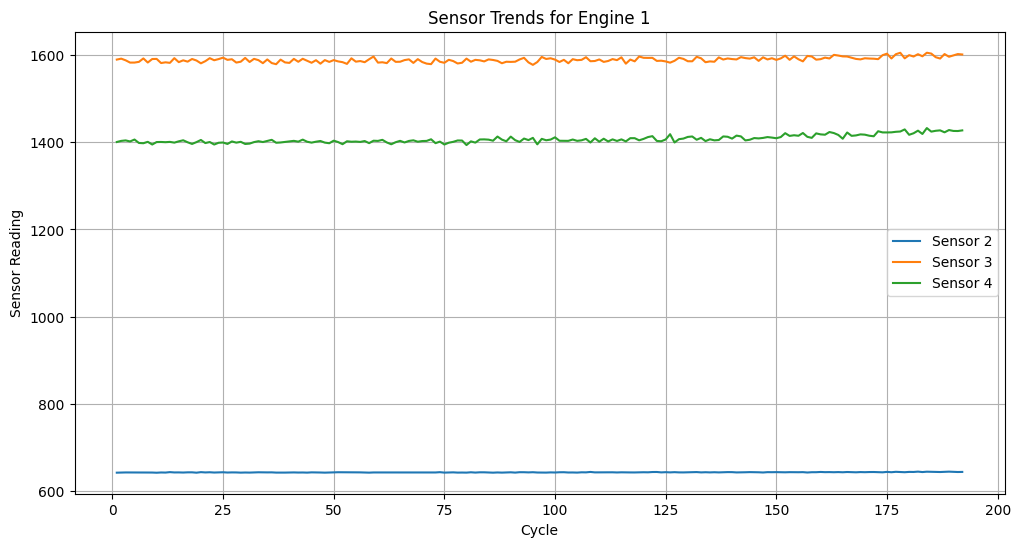

In [ ]:
unit_id = 1
df_unit = df[df['unit_number'] == unit_id]

plt.figure(figsize=(12, 6))
plt.plot(df_unit['time_in_cycles'], df_unit['sensor_2'], label='Sensor 2')
plt.plot(df_unit['time_in_cycles'], df_unit['sensor_3'], label='Sensor 3')
plt.plot(df_unit['time_in_cycles'], df_unit['sensor_4'], label='Sensor 4')
plt.xlabel('Cycle')
plt.ylabel('Sensor Reading')
plt.title(f'Sensor Trends for Engine {unit_id}')
plt.legend()
plt.grid(True)
plt.show()

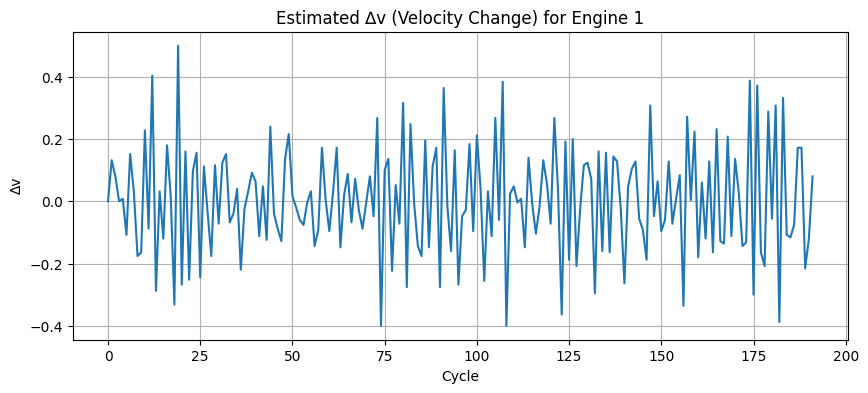

In [ ]:
# We'll use sensor_2 (e.g., fan speed) as a velocity proxy
df['velocity_proxy'] = df.groupby('unit_number')['sensor_2'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())  # min-max normalization per engine
)

# Calculate ∆v = change in velocity over time
df['delta_v'] = df.groupby('unit_number')['velocity_proxy'].diff().fillna(0)

# Plot ∆v for unit 1
plt.figure(figsize=(10,4))
plt.plot(df[df.unit_number == 1]['delta_v'])
plt.title('Estimated ∆v (Velocity Change) for Engine 1')
plt.xlabel('Cycle')
plt.ylabel('∆v')
plt.grid(True)
plt.show()

In [ ]:
# Choose a subset of sensors + operational settings for modeling
selected_features = ['op_setting_1', 'op_setting_2', 'op_setting_3',
                     'sensor_2', 'sensor_3', 'sensor_4', 'velocity_proxy', 'delta_v']

# Normalize per-sensor globally (or you could normalize per-engine)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

In [ ]:
def label_maneuver(row, max_cycle):
    if row['time_in_cycles'] > max_cycle * 0.90:
        return 3  # Failure zone
    elif row['delta_v'] > 0.1:
        return 1  # Climb
    elif row['delta_v'] < -0.1:
        return 2  # Descent
    else:
        return 0  # Cruise

# Apply to each engine
df['label'] = 0
for unit in df['unit_number'].unique():
    max_cycle = df[df['unit_number'] == unit]['time_in_cycles'].max()
    df.loc[df['unit_number'] == unit, 'label'] = df[df['unit_number'] == unit].apply(
        lambda row: label_maneuver(row, max_cycle), axis=1
    )

df['label'].value_counts()

,count
label,
2,8464
1,8459
3,2106
0,1602


In [ ]:
sequence_length = 30
sequences = []
labels = []

for unit in df['unit_number'].unique():
    unit_data = df[df['unit_number'] == unit][selected_features + ['label']].values
    for i in range(len(unit_data) - sequence_length):
        seq = unit_data[i:i+sequence_length, :-1]  # exclude label from input
        lbl = unit_data[i+sequence_length-1, -1]   # label at final timestep
        sequences.append(seq)
        labels.append(lbl)

X = np.array(sequences)
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 8)
y shape: (17631,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train samples: 14104, Test samples: 3527


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Build DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
class AeroSenseTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [B, T, F]
        x = self.embedding(x)           # [B, T, D]
        x = self.transformer(x)         # [B, T, D]
        x = x[:, -1, :]                 # Take last timestep
        return self.classifier(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AeroSenseTransformer(
    input_dim=X.shape[2],       # 8 features
    model_dim=64,
    num_heads=4,
    num_layers=2,
    num_classes=4,
    dropout=0.1
).to(device)

In [ ]:
criterion_cls = nn.CrossEntropyLoss()

def physics_loss(batch_x, output_logits):
    # Approximate ∆v from input
    delta_v_input = batch_x[:, 1:, 6] - batch_x[:, :-1, 6]  # ∆v across sequence
    mean_delta_v = torch.mean(delta_v_input, dim=1)

    # Predict class and map to expected motion
    expected_motion = torch.argmax(output_logits, dim=1).float()
    target_trend = torch.where(expected_motion == 1, 1.0, torch.where(expected_motion == 2, -1.0, 0.0))

    physics_term = torch.mean((mean_delta_v - target_trend) ** 2)
    return physics_term

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10
lambda_phys = 0.5  # weight for physics-informed loss

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)

        loss_cls = criterion_cls(logits, batch_y)
        loss_phys = physics_loss(batch_x, logits)
        loss = loss_cls + lambda_phys * loss_phys

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 203.4243
Epoch 2, Loss: 134.9697
Epoch 3, Loss: 123.9104
Epoch 4, Loss: 118.8965
Epoch 5, Loss: 116.9440
Epoch 6, Loss: 114.8970
Epoch 7, Loss: 114.0147
Epoch 8, Loss: 112.2581
Epoch 9, Loss: 111.9626
Epoch 10, Loss: 112.2976


In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        logits = model(batch_x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(batch_y.numpy())
        y_pred.extend(preds)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=[
    "Cruise (0)", "Climb (1)", "Descent (2)", "Failure (3)"
]))

              precision    recall  f1-score   support

  Cruise (0)       0.94      0.92      0.93       253
   Climb (1)       0.98      0.98      0.98      1439
 Descent (2)       0.97      0.98      0.98      1434
 Failure (3)       0.88      0.88      0.88       401

    accuracy                           0.96      3527
   macro avg       0.94      0.94      0.94      3527
weighted avg       0.96      0.96      0.96      3527



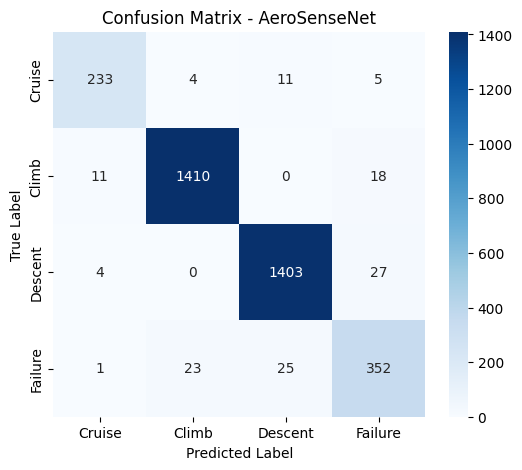

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Cruise", "Climb", "Descent", "Failure"],
            yticklabels=["Cruise", "Climb", "Descent", "Failure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - AeroSenseNet")
plt.show()

In [ ]:
accuracy = np.mean(np.array(y_pred) == np.array(y_true))
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 96.34%


In [ ]:
# Re-initialize the model from scratch
model_ablation = AeroSenseTransformer(
    input_dim=X.shape[2],
    model_dim=64,
    num_heads=4,
    num_layers=2,
    num_classes=4,
    dropout=0.1
).to(device)

optimizer = torch.optim.AdamW(model_ablation.parameters(), lr=1e-4)
criterion_cls = nn.CrossEntropyLoss()

# Train without physics-informed loss
print("Training model without physics-informed loss...")
for epoch in range(10):  # keep same epoch count
    model_ablation.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model_ablation(batch_x)
        loss = criterion_cls(logits, batch_y)  # ONLY classification loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Ablation] Epoch {epoch+1}, Loss: {total_loss:.4f}")

Training model without physics-informed loss...
[Ablation] Epoch 1, Loss: 107.7709
[Ablation] Epoch 2, Loss: 47.2623
[Ablation] Epoch 3, Loss: 36.6810
[Ablation] Epoch 4, Loss: 33.9770
[Ablation] Epoch 5, Loss: 29.8075
[Ablation] Epoch 6, Loss: 29.2760
[Ablation] Epoch 7, Loss: 27.8918
[Ablation] Epoch 8, Loss: 25.3753
[Ablation] Epoch 9, Loss: 25.4300
[Ablation] Epoch 10, Loss: 25.1410


In [ ]:
model_ablation.eval()
y_pred_ablation = []
y_true_ablation = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits = model_ablation(batch_x.to(device))
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_ablation.extend(preds)
        y_true_ablation.extend(batch_y.numpy())

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Classification Report (No Physics Loss):")
print(classification_report(y_true_ablation, y_pred_ablation, target_names=[
    "Cruise (0)", "Climb (1)", "Descent (2)", "Failure (3)"
]))

acc_ablation = accuracy_score(y_true_ablation, y_pred_ablation)
print(f"Test Accuracy (No Physics Loss): {acc_ablation*100:.2f}%")

Classification Report (No Physics Loss):
              precision    recall  f1-score   support

  Cruise (0)       0.96      0.72      0.82       253
   Climb (1)       0.96      0.97      0.96      1439
 Descent (2)       0.97      0.98      0.98      1434
 Failure (3)       0.84      0.91      0.87       401

    accuracy                           0.95      3527
   macro avg       0.93      0.90      0.91      3527
weighted avg       0.95      0.95      0.95      3527

Test Accuracy (No Physics Loss): 94.90%


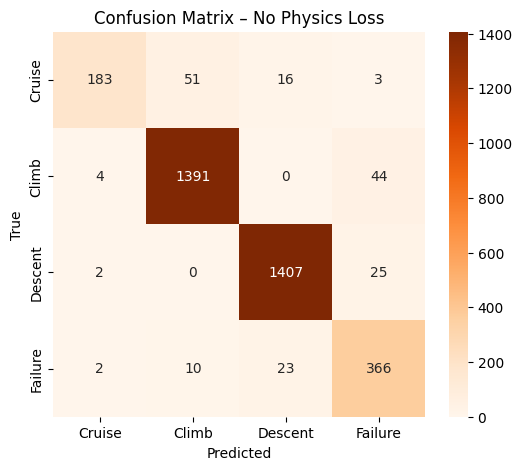

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_ablation = confusion_matrix(y_true_ablation, y_pred_ablation)

plt.figure(figsize=(6,5))
sns.heatmap(conf_ablation, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Cruise", "Climb", "Descent", "Failure"],
            yticklabels=["Cruise", "Climb", "Descent", "Failure"])
plt.title("Confusion Matrix – No Physics Loss")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
class AttentionReturnEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2, self.attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                                 key_padding_mask=src_key_padding_mask,
                                                 need_weights=True,
                                                 average_attn_weights=False)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [ ]:
class AeroSenseTransformerWithAttention(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.encoder_layers = nn.ModuleList([
            AttentionReturnEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.encoder_layers:
            x = layer(x)
        self.attn_weights = self.encoder_layers[-1].attn_weights  # Shape: [B, Heads, T, T]
        return self.classifier(x[:, -1, :])

In [ ]:
# Load trained weights if saved earlier, else re-train this version for 1 epoch
model_with_attn = AeroSenseTransformerWithAttention(
    input_dim=X.shape[2],
    model_dim=64,
    num_heads=4,
    num_layers=2,
    num_classes=4
).to(device)

# Optional: load from checkpoint if you saved earlier
# model_with_attn.load_state_dict(torch.load("best_model.pt"))

model_with_attn.eval()

AeroSenseTransformerWithAttention(
  (embedding): Linear(in_features=8, out_features=64, bias=True)
  (encoder_layers): ModuleList(
    (0-1): 2 x AttentionReturnEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=4,

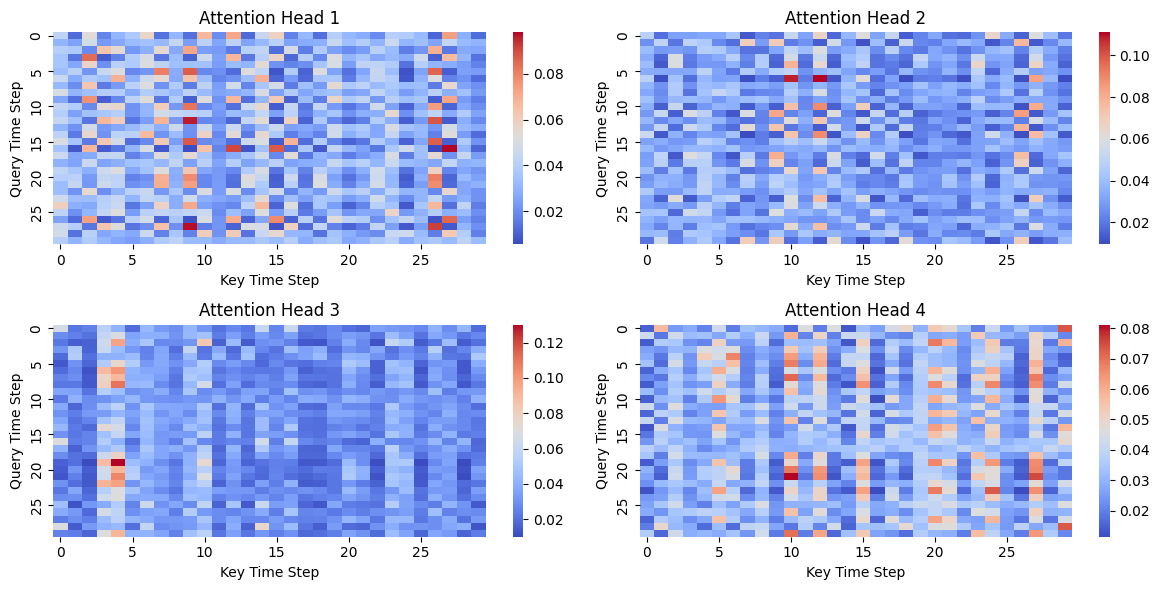

In [ ]:
# Pick one test sample to visualize
sample_x = X_test_tensor[10:11].to(device)  # Shape: [1, 30, 8]
_ = model_with_attn(sample_x)

# Extract attention
attn = model_with_attn.attn_weights.detach().cpu().squeeze(0)  # Shape: [Heads, T, T]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for h in range(attn.shape[0]):
    plt.subplot(2, 2, h+1)
    sns.heatmap(attn[h], cmap='coolwarm', xticklabels=5, yticklabels=5)
    plt.title(f'Attention Head {h+1}')
    plt.xlabel("Key Time Step")
    plt.ylabel("Query Time Step")

plt.tight_layout()
plt.show()

In [ ]:
# Upload FD002 file to Colab (or load from your system if mounted)
df_fd002 = pd.read_csv("/content/test_FD002.txt", sep="\s+", header=None, names=column_names)
df_fd002.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740


In [ ]:
# Reuse same sensor subset
df_fd002['velocity_proxy'] = df_fd002.groupby('unit_number')['sensor_2'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
df_fd002['delta_v'] = df_fd002.groupby('unit_number')['velocity_proxy'].diff().fillna(0)

# Normalize selected features using scaler from FD001
df_fd002[selected_features] = scaler.transform(df_fd002[selected_features])

In [ ]:
def label_maneuver(row, max_cycle):
    if row['time_in_cycles'] > max_cycle * 0.90:
        return 3
    elif row['delta_v'] > 0.1:
        return 1
    elif row['delta_v'] < -0.1:
        return 2
    else:
        return 0

df_fd002['label'] = 0
for unit in df_fd002['unit_number'].unique():
    max_cycle = df_fd002[df_fd002['unit_number'] == unit]['time_in_cycles'].max()
    df_fd002.loc[df_fd002['unit_number'] == unit, 'label'] = df_fd002[df_fd002['unit_number'] == unit].apply(
        lambda row: label_maneuver(row, max_cycle), axis=1
    )

In [ ]:
sequences_fd002 = []
labels_fd002 = []

for unit in df_fd002['unit_number'].unique():
    unit_data = df_fd002[df_fd002['unit_number'] == unit][selected_features + ['label']].values
    for i in range(len(unit_data) - sequence_length):
        seq = unit_data[i:i+sequence_length, :-1]
        lbl = unit_data[i+sequence_length-1, -1]
        sequences_fd002.append(seq)
        labels_fd002.append(lbl)

X_fd002 = torch.tensor(np.array(sequences_fd002), dtype=torch.float32)
y_fd002 = torch.tensor(np.array(labels_fd002), dtype=torch.long)

print("FD002 samples:", X_fd002.shape)

FD002 samples: torch.Size([26252, 30, 8])


In [ ]:
model.eval()
fd002_loader = DataLoader(TensorDataset(X_fd002, y_fd002), batch_size=64)

y_true_fd002, y_pred_fd002 = [], []

with torch.no_grad():
    for batch_x, batch_y in fd002_loader:
        batch_x = batch_x.to(device)
        logits = model(batch_x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true_fd002.extend(batch_y.numpy())
        y_pred_fd002.extend(preds)

In [ ]:
print("Cross-Domain Report (FD002 using FD001-trained model):")
print(classification_report(y_true_fd002, y_pred_fd002, target_names=[
    "Cruise (0)", "Climb (1)", "Descent (2)", "Failure (3)"
]))

acc_fd002 = np.mean(np.array(y_true_fd002) == np.array(y_pred_fd002))
print(f"Cross-Domain Accuracy (FD002): {acc_fd002*100:.2f}%")

Cross-Domain Report (FD002 using FD001-trained model):
              precision    recall  f1-score   support

  Cruise (0)       0.00      0.00      0.00      4100
   Climb (1)       0.00      0.00      0.00      9426
 Descent (2)       0.00      0.00      0.00      9483
 Failure (3)       0.12      1.00      0.22      3243

    accuracy                           0.12     26252
   macro avg       0.03      0.25      0.05     26252
weighted avg       0.02      0.12      0.03     26252

Cross-Domain Accuracy (FD002): 12.35%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


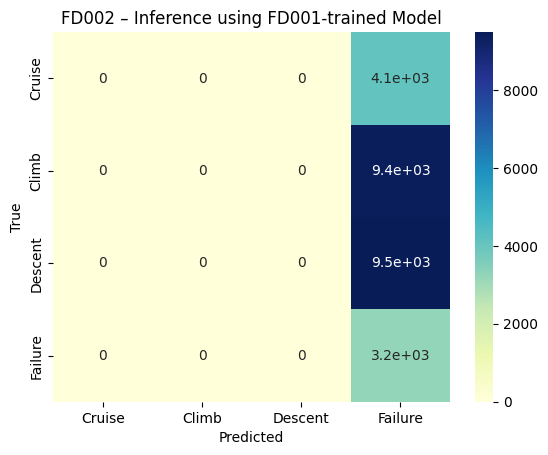

In [ ]:
sns.heatmap(confusion_matrix(y_true_fd002, y_pred_fd002), annot=True, cmap="YlGnBu",
            xticklabels=["Cruise", "Climb", "Descent", "Failure"],
            yticklabels=["Cruise", "Climb", "Descent", "Failure"])
plt.title("FD002 – Inference using FD001-trained Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()